# Weight initialization and regularization
We added weight initialization and weight regularization to Network 2.

## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/AA 2024-2025/DA drive/AN2DL/Homework

Mounted at /gdrive
/gdrive/My Drive/AA 2024-2025/DA drive/AN2DL/Homework


## ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [3]:
# Load the training data
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

In [ ]:
shrek = 12760
rick_rol = 13580

# Find indices where the images don't match Shrek or Rick Astley
indices = [i for i in range(len(X)) if (not ((np.array_equal(X[i], X[shrek]) or np.array_equal(X[i], X[rick_rol]))))]

# Create new arrays using the selected indices
new_images = X[indices]
new_labels = y[indices]

In [ ]:
np.savez('filtered_data.npz', images=new_images, labels=new_labels)

In [4]:
# Load the training data
data = np.load('filtered_data.npz')
X = data['images']
y = data['labels']

In [5]:
# Divide train, val and test sets
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (9567, 96, 96, 3)
Training-Validation Label Shape: (9567, 1)
Test Data Shape: (2392, 96, 96, 3)
Test Label Shape: (2392, 1)


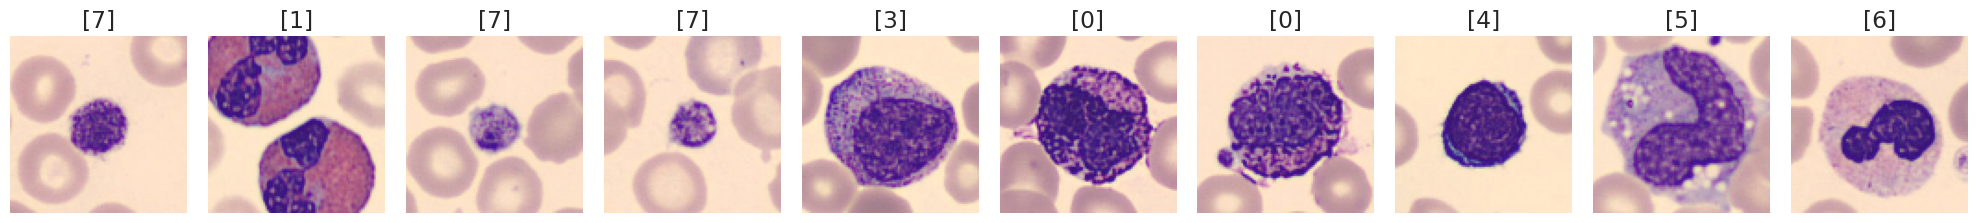

In [6]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X_train_val)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_train_val[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{y_train_val[idx]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [7]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
6    1850
1    1759
3    1653
7    1302
2     866
5     789
0     675
4     673
Name: count, dtype: int64


In [8]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [9]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (8610, 96, 96, 3)
Training Label Shape: (8610, 8)
Validation Data Shape: (957, 96, 96, 3)
Validation Label Shape: (957, 8)


## 🛠️ Train and Save the Model

In [10]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [11]:
# Number of training epochs
epochs = 500

# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 500
Batch Size: 128
Learning Rare: 0.001


In [30]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl, models as tfk, losses, optimizers, regularizers, initializers

def build_model(
    input_shape,
    output_shape,
    learning_rate,
    seed,
    augmentation=None,  # Add augmentation as an optional parameter
    l2_lambda=5e-4
):
    tf.random.set_seed(seed)

    inputs = tfkl.Input(shape=input_shape, name='Input')

    # Apply augmentation if provided
    x = augmentation(inputs) if augmentation else inputs

    # Downsizing images
    x = tfkl.Resizing(32, 32, interpolation="bilinear")(x)

    # Weight initialization and regularization
    initializer = initializers.LecunNormal(seed=seed)
    regularizer = regularizers.l2(l2_lambda)

    x = tfkl.Conv2D(
        filters=32, kernel_size=3, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, name='conv1'
    )(x)
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

    x = tfkl.Conv2D(
        filters=64, kernel_size=3, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, name='conv2'
    )(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    x = tfkl.Flatten(name='flatten')(x)
    x = tfkl.Dense(units=output_shape, kernel_initializer=initializer, kernel_regularizer=regularizer, name='dense')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Corrected loss and optimizer imports
    loss = losses.CategoricalCrossentropy()
    optimizer = optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [31]:
# Define a data augmentation pipeline with random flip, brightness, and translation
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
    tfkl.RandomTranslation(0.2,0.2),
], name='preprocessing')

# Build the model with specified input and output shapes
model = build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate, seed=seed, augmentation=augmentation)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

import tensorflow as tf
from tensorflow.keras.utils import plot_model  # Import plot_model directly

# Plot the model architecture with the correct import
# plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_5 (RandomFlip)     │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_brightness_5            │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomBrightness)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_5           │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ resizing_4 (Resizing)               │ (None, 32, 32, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 32, 32, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 32, 32, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 16, 16, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 16, 16, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 16, 16, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 8, 8, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 4096)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 8)                    │        32,776 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 8)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 52,168 (203.78 KB)

 Trainable params: 52,168 (203.78 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping directly

# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [33]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'NoPainNoTrain'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2626 - loss: 1.9755 - val_accuracy: 0.5141 - val_loss: 1.3100
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5074 - loss: 1.3514 - val_accuracy: 0.6834 - val_loss: 1.0558
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6155 - loss: 1.1056 - val_accuracy: 0.6813 - val_loss: 0.9442
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6756 - loss: 0.9548 - val_accuracy: 0.7586 - val_loss: 0.8411
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7163 - loss: 0.8356 - val_accuracy: 0.7701 - val_loss: 0.7458
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7413 - loss: 0.7759 - val_accuracy: 0.8182 - val_loss: 0.6755
Epoch 7/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7530 - loss: 0.7443 - val_accuracy: 0.8349 - val_loss: 0.6273
Epoch 8/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7789 - loss: 0.6895 - val_accuracy: 0.

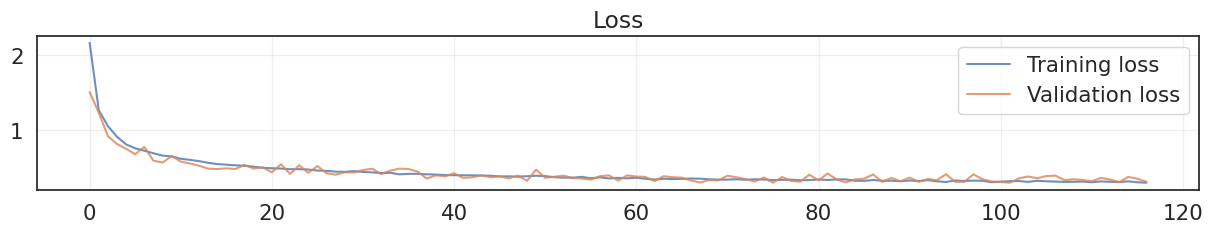

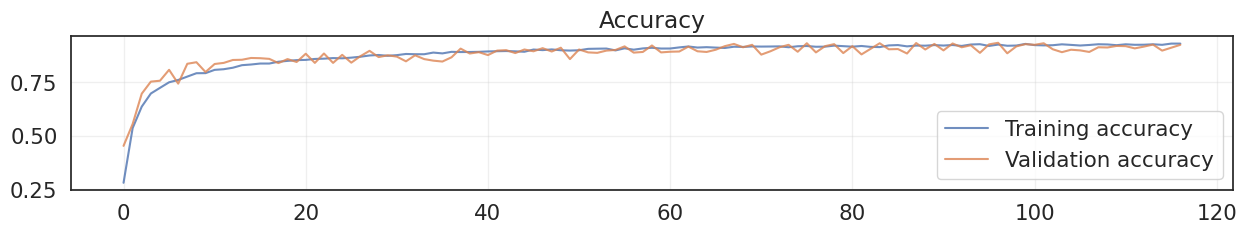

In [26]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [34]:
# Load the saved model
model = tf.keras.models.load_model('NoPainNoTrain91.75.keras')

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

In [35]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=y, yticklabels=y, cmap='Blues')
# plt.xlabel('True labels')
# plt.ylabel('Predicted labels')
# plt.show()

Accuracy score over the test set: 0.9176
Precision score over the test set: 0.9198
Recall score over the test set: 0.9176
F1 score over the test set: 0.9173


## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('NoGainNoTrain94.15.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py NoGainNoTrain94.15.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 55%)
  adding: NoGainNoTrain94.15.keras (deflated 14%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>